In [35]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import math
import time
import random
from astropy.stats import *
from scipy.integrate import simps
from concurrent.futures import ProcessPoolExecutor   
# plt.style.use('classic')
import json

from simulation_functions import *

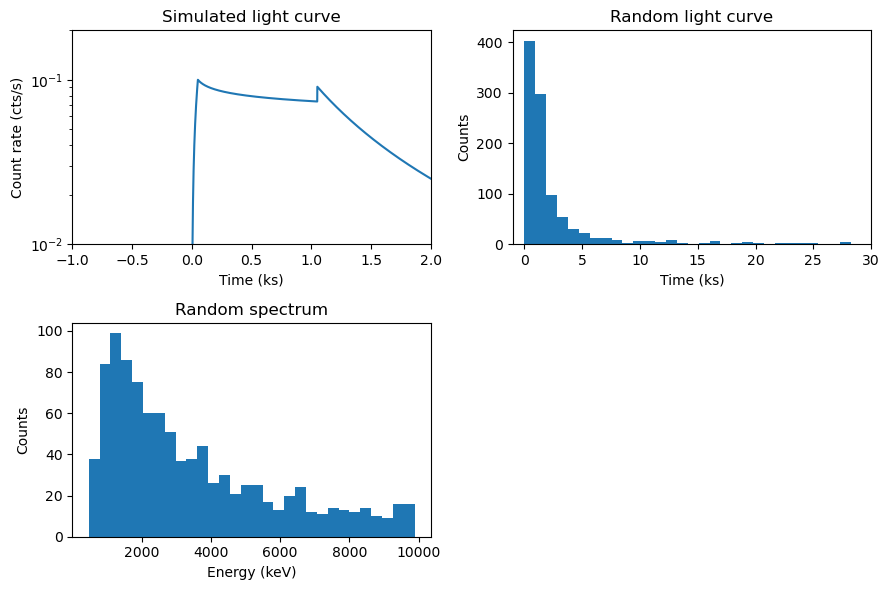

In [2]:
t, function, simulated_time, energy = simulate_FXRT(
    T_exp=30, 
    t_bin=1,
    t_0=0, 
    background=5.6e-5, 
    total_counts=1000, 
    peak=1e-1
)

fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# light curve
axs[0, 0].plot(t / 1000, function, label='Input light curve')
axs[0, 0].set_title('Simulated light curve')
axs[0, 0].set_xlabel('Time (ks)')
axs[0, 0].set_ylabel('Count rate (cts/s)')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(-1, 2)
axs[0, 0].set_ylim(1e-2, 2e-1)

# random light curve
axs[0, 1].hist(simulated_time / 1000, bins=30, label='Simulated light curve')
axs[0, 1].set_title('Random light curve')
axs[0, 1].set_xlabel('Time (ks)')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(-1, 30)

# spectrum
axs[1, 0].hist(energy, bins=30, label='Random spectrum')
axs[1, 0].set_title('Random spectrum')
axs[1, 0].set_xlabel('Energy (keV)')
axs[1, 0].set_ylabel('Counts')

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# peak_fluxes = 10**np.arange(-13.0, -12.5, 0.1) # erg/cm^2/s
peak_flux = 10**-12.5 # erg/cm^2/s
background = 5.6e-5 # cts/s
theta = 5.0 # arcmin
T_exp = 32 # ks
simulations = 1000

perf_time_1 = time.perf_counter()
probability_0 = simulate_detection(T_exp, peak_flux, background, theta, simulations)
perf_time_2 = time.perf_counter()
probability_1 = simulate_detection_parallel_simulations(T_exp, peak_flux, background, theta, simulations)
perf_time_3 = time.perf_counter()

print(probability_0, perf_time_2 - perf_time_1)
print(probability_1, perf_time_3 - perf_time_2)

0.999 21.299272599979304
0.999 14.565185000014026


In [6]:
chandra_exposure_times = np.array([
    4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32, 36, 40, 44, 50
]) # possible exposure times in kiloseconds
peak_fluxes = 10**np.arange(-13.0, -12.5, 0.1) # peak fluxes in erg/cm^2/s
background_at_off_axis_angle = np.array([
    (5.6e-5, 5.0),
    (2.5e-4, 8.0),
    (7.0e-4, 11.0)
]) # (background count rate, off axis angle)
simulations = 1000 # number of simulations

detection_probabilities = {}
for F_peak in peak_fluxes:
    print(f'log F_peak = {np.log10(F_peak):.1f}')
    detection_probabilities[str(F_peak)] = {}
    for background, theta in background_at_off_axis_angle:
        detection_probabilities[str(F_peak)][str(background)] = []
        print(f'\tbackground = {background:.2e}, theta = {theta:.1f}')
        for T_exp in chandra_exposure_times:
            print(f'\t\tT_exp = {T_exp:.1f} -> ')
            t_perf_1 = time.perf_counter()
            probability = simulate_detection_parallel_simulations(T_exp, F_peak, background, theta, simulations)
            t_perf_2 = time.perf_counter()
            print(f'\t\t\tP = {probability:.2f} ({t_perf_2 - t_perf_1:.2f} s)')
            detection_probabilities[str(F_peak)][str(background)].append(probability)

print(detection_probabilities)
with open('detection_probabilities_window_20.json', 'w') as file:
    json.dump(detection_probabilities, file, indent=4)

log F_peak = -13.0
	background = 5.60e-05, theta = 5.0
		T_exp = 4.0 -> 
			P = 0.03 (5.90 s)
		T_exp = 6.0 -> 
			P = 0.04 (6.20 s)
		T_exp = 8.0 -> 
			P = 0.06 (6.93 s)
		T_exp = 10.0 -> 
			P = 0.07 (7.95 s)
		T_exp = 12.0 -> 
			P = 0.06 (8.16 s)
		T_exp = 14.0 -> 
			P = 0.10 (8.43 s)
		T_exp = 16.0 -> 
			P = 0.09 (8.80 s)
		T_exp = 18.0 -> 
			P = 0.09 (9.08 s)
		T_exp = 20.0 -> 
			P = 0.09 (14.94 s)
		T_exp = 24.0 -> 
			P = 0.09 (19.31 s)
		T_exp = 28.0 -> 
			P = 0.08 (20.45 s)
		T_exp = 32.0 -> 
			P = 0.08 (23.51 s)
		T_exp = 36.0 -> 
			P = 0.08 (24.58 s)
		T_exp = 40.0 -> 
			P = 0.07 (25.32 s)
		T_exp = 44.0 -> 
			P = 0.08 (29.36 s)
		T_exp = 50.0 -> 
			P = 0.06 (30.85 s)
	background = 2.50e-04, theta = 8.0
		T_exp = 4.0 -> 
			P = 0.03 (8.24 s)
		T_exp = 6.0 -> 
			P = 0.06 (8.62 s)
		T_exp = 8.0 -> 
			P = 0.05 (9.27 s)
		T_exp = 10.0 -> 
			P = 0.07 (9.12 s)
		T_exp = 12.0 -> 
			P = 0.08 (9.20 s)
		T_exp = 14.0 -> 
			P = 0.07 (9.51 s)
		T_exp = 16.0 -> 
			P = 0

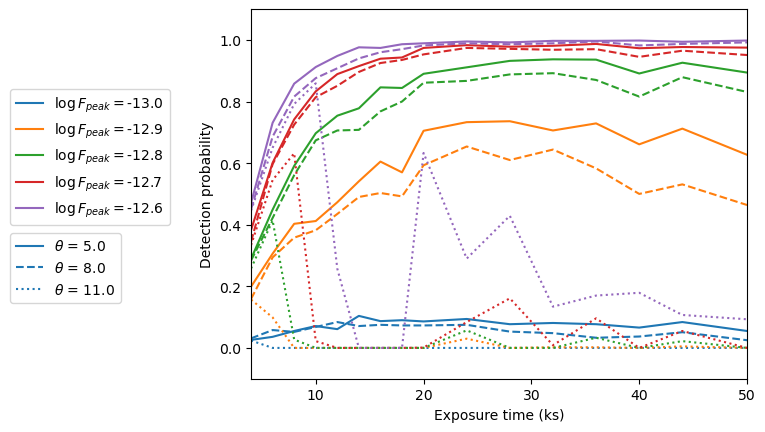

In [39]:
with open('detection_probabilities_window_20.json', 'r') as file:
    detection_probabilities_plot = json.load(file)

fig, axs = plt.subplots()

cmap = matplotlib.cm.get_cmap('tab10')
colors = [cmap(i) for i in np.arange(0, 1, 0.1)]
line_style = ['-','--',':','-.'][0:len(background_at_off_axis_angle)]

for i, F_peak in enumerate(peak_fluxes):
    for j, (background, theta) in enumerate(background_at_off_axis_angle):
        axs.plot(
            chandra_exposure_times, 
            detection_probabilities_plot[str(F_peak)][str(background)], 
            color=colors[i],
            linestyle=line_style[j]
        )

# Legend for colors and peak fluxes
color_legend = []
for i, F_peak in enumerate(peak_fluxes):
    color_legend.append(plt.Line2D([0], [0], color=colors[i], label='$\log F_{peak} = $' + f'{np.log10(F_peak):.1f}'))
legend_1 = plt.legend(handles=color_legend, bbox_to_anchor=(-0.5, 0.6), loc='center left')

# Legend for line styles and angles
line_style_legend = []
for j, (_, theta) in enumerate(background_at_off_axis_angle):
    line_style_legend.append(plt.Line2D([0], [0], linestyle=line_style[j], label=f'$\\theta$ = {theta:.1f}'))
legend_2 = plt.legend(handles=line_style_legend, bbox_to_anchor=(-0.5, 0.3), loc='center left')

axs.set_xlim(chandra_exposure_times[0], chandra_exposure_times[-1])
axs.set_ylim(-0.1, 1.1)

axs.set_xlabel('Exposure time (ks)')
axs.set_ylabel('Detection probability')

axs.add_artist(legend_1)

plt.savefig('plots/window_20ks.pdf', bbox_inches='tight')